In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [2]:
# Load pre-processed data
SG_CRC_BA = pd.read_csv("SG_CRC_BA.csv", index_col=0, delimiter=",")
SG_CRC_BA

,g__Acetivibrio,g__Acetobacterium,g__Acetobacteroides,g__Acidaminococcus,g__Actinobacillus,g__Actinomyces,g__Acutalibacter,g__Adlercreutzia,g__Aeromonas,g__Agathobacter,...,Age.at.Diagnosis,Site.of.Primary.Colorectal.tumour,Side,Grade,TNM,Stage,iCMS,CMS,group3,group5
patient_id,,,,,,,,,,,,,,,,,,,,,
X1030,0.000096,0.000000,0.000000,0.000048,0.000000,0.000000,0.000192,0.000000,0.000144,0.011379,...,72.0,Sigmoid colon,Left,2,pT3N0(0/20)M0,IIA,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
X106,0.000045,0.000000,0.000000,0.000119,0.000000,0.000015,0.000030,0.000030,0.000015,0.000015,...,72.0,Transverse colon,Right,3,T4aN2(4/29)M0,IIIC,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
X1076,0.000000,0.000000,0.000000,0.000085,0.000000,0.000170,0.000000,0.000000,0.001190,0.000170,...,45.0,Cecum,Right,2,pT3N2(6/12)M1,IV,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
X1079,0.000018,0.000027,0.000002,0.006718,0.000006,0.000010,0.000005,0.000022,0.000166,0.001404,...,65.0,Splenic flexure,Left,2,pT4aN0(0/6)M1,IV,iCMS3,CMS4,iCMS3_MSS,iCMS3_fibrotic
X1117,0.000000,0.000000,0.000000,0.000519,0.000000,0.000000,0.000000,0.000000,0.000000,0.000623,...,45.0,Rectosigmoid junction,Left,2,pT3N0(0/12)M1,IV,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X1658,0.000025,0.000025,0.000025,0.000738,0.000000,0.000000,0.000000,0.000051,0.000025,0.000993,...,59.0,Rectum,Left,2,T3N2b(8/22)M1,IV,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
X1662,0.000044,0.000049,0.000087,0.000049,0.000000,0.000005,0.000073,0.000014,0.000063,0.018181,...,67.0,Rectum,Left,2,T3N1a(1/36)M0,IIIB,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS
X1664,0.000000,0.000000,0.000000,0.000281,0.000000,0.000000,0.000000,0.000000,0.000000,0.000843,...,62.0,Sigmoid colon,Left,2,T3N2a(6/29)M0,IIIC,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic


In [3]:
class_counts = SG_CRC_BA['BRAF'].value_counts()
print(class_counts)

BRAF
wt     95
mut    11
Name: count, dtype: int64


In [4]:
# Prepare features and target variable
X = SG_CRC_BA.drop(['TMB', 'KRAS', 'BRAF', 'NRAS', 'TP53', 'APC', 'PIK3CA',
       'PIK3R1', 'SMAD4', 'ERBB4', 'RNF43', 'ZNRF3', 'KIT', 'TGFBR2',
       'Vital.status', 'MSI.Status', 'CRIS', 'Gender', 'Age.at.Diagnosis',
       'Site.of.Primary.Colorectal.tumour', 'Side', 'Grade', 'TNM', 'Stage',
       'iCMS', 'CMS', 'group3', 'group5'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
y = SG_CRC_BA['BRAF']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))
print("Shape of y:", X_scaled.shape)
print("Shape of y:", y.shape)

Unique values of y: ['mut' 'wt']
Unique values of y: [0 1]
Shape of y: (106, 212)
Shape of y: (106,)


In [5]:
# Oversampling to ensure class balance
from imblearn.over_sampling import SMOTE
#oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
#X_scaled, y = oversampler.fit_resample(X_scaled,y)

sm = SMOTE(sampling_strategy='not majority', k_neighbors= 5, random_state=42)
X_scaled, y = sm.fit_resample(X_scaled, y)

print(X_scaled.shape)
print(y.shape)


(190, 212)
(190,)


Test on the single model:

Best Parameters: {'alpha': 1, 'colsample_bytree': 0.8, 'eta': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
Best Score: 0.9802150537634409
Test Set Accuracy: 0.9736842105263158


<Figure size 800x600 with 0 Axes>

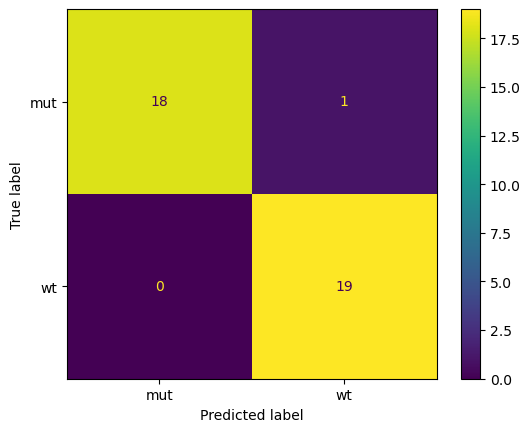

              precision    recall  f1-score   support

         mut       1.00      0.95      0.97        19
          wt       0.95      1.00      0.97        19

    accuracy                           0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.97      0.97      0.97        38



In [6]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True, random_state=1, stratify=y)

# Define parameters for XGBoost model
params = {
    'max_depth': [3, 4, 5],
    'eta': [0.01, 0.1],
    'alpha': [1],
    'colsample_bytree': [0.8],
    'subsample': [0.8, 0.9],
    'n_estimators':[100],
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter set selection
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=cv)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['mut', 'wt'])
plt.figure(figsize=(8, 6))
cm_display.plot()
plt.show()

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred, target_names=['mut', 'wt'])
print(report)


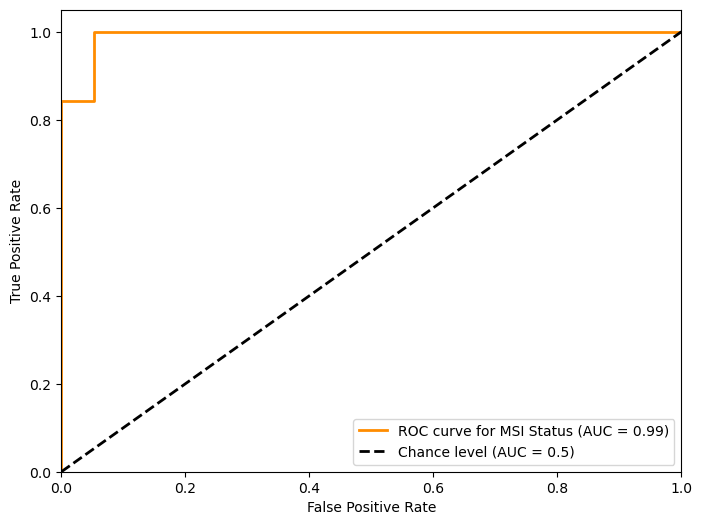

In [7]:
# AUROC curve

y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve for MSI Status (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, label=f'Chance level (AUC = 0.5)', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

C:\Users\Zhongyuan\AppData\Local\Temp\ipykernel_23540\2900214027.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")


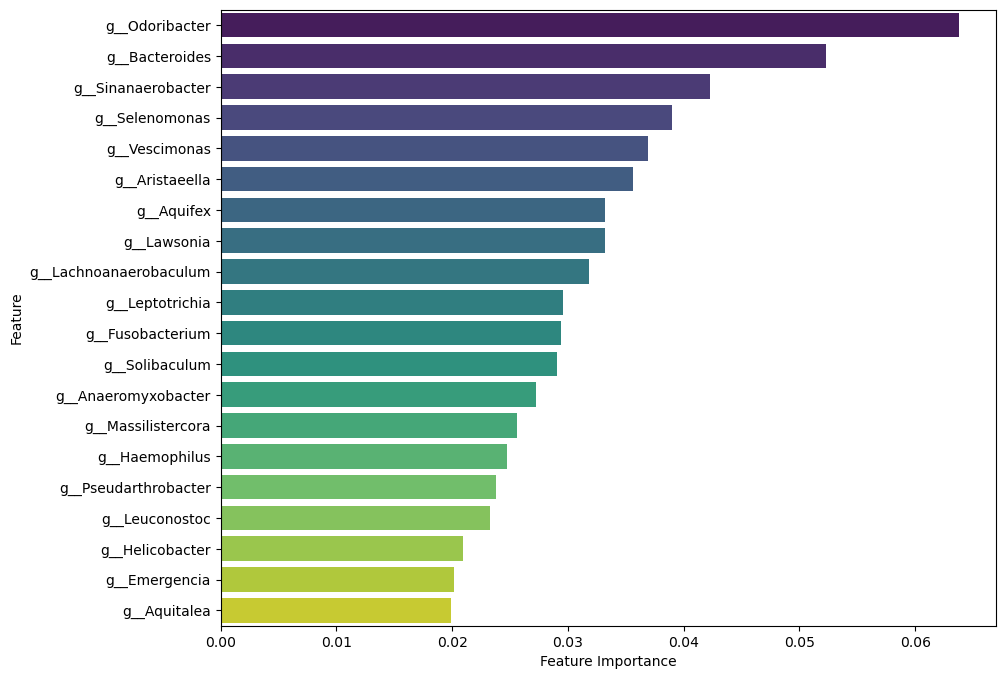

In [8]:
# Train XGBoost model with best parameters for calculating feature importances
best_xgb_model = xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss', **best_params)
best_xgb_model.fit(X_train, y_train)

feature_importances = best_xgb_model.feature_importances_
top_20_indices = feature_importances.argsort()[::-1][:20]
feature_names = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

In [9]:
print(feature_names[top_20_indices])

Index(['g__Odoribacter', 'g__Bacteroides', 'g__Sinanaerobacter',
       'g__Selenomonas', 'g__Vescimonas', 'g__Aristaeella', 'g__Aquifex',
       'g__Lawsonia', 'g__Lachnoanaerobaculum', 'g__Leptotrichia',
       'g__Fusobacterium', 'g__Solibaculum', 'g__Anaeromyxobacter',
       'g__Massilistercora', 'g__Haemophilus', 'g__Pseudarthrobacter',
       'g__Leuconostoc', 'g__Helicobacter', 'g__Emergencia', 'g__Aquitalea'],
      dtype='object')


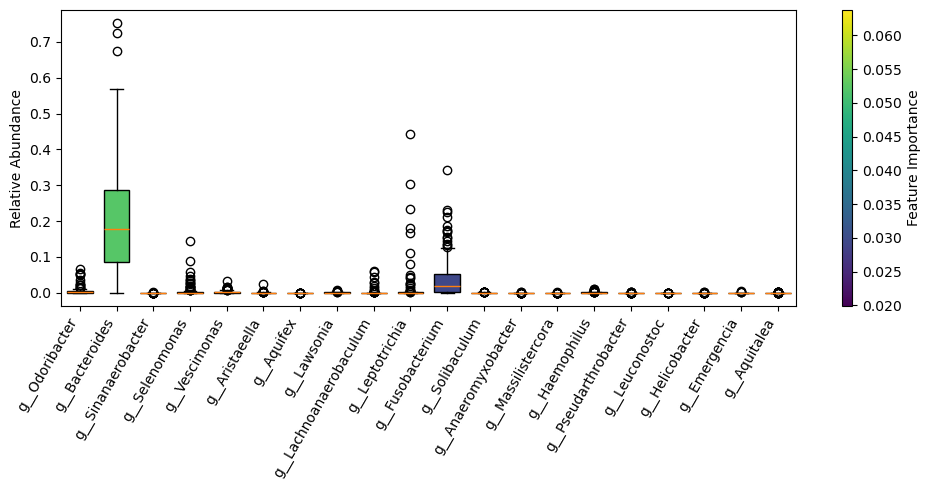

In [10]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

top_20_feature_names = feature_names[top_20_indices]

# Normalize feature importances
norm = Normalize(vmin=min(feature_importances[top_20_indices]), vmax=max(feature_importances[top_20_indices]))
cmap = plt.get_cmap('viridis')  # Choose a colormap
colors = [cmap(norm(importance)) for importance in feature_importances[top_20_indices]]

data = {}

for column_name in top_20_feature_names:
    data[column_name] = X[column_name]

fig, ax = plt.subplots(figsize=(10, 5))

# Plot each box with the corresponding color based on feature importance
for i, (key, value) in enumerate(data.items()):
    box = ax.boxplot(value, positions=[i + 1], widths=0.7, patch_artist=True,
                     boxprops=dict(facecolor=colors[i], color='black'),
                     whiskerprops=dict(color='black'))

ax.set_ylabel('Relative Abundance', fontsize=10)
ax.set_xticks(range(1, len(data) + 1))
ax.set_xticklabels(data.keys(), rotation=60, ha='right', fontsize=10)
plt.tight_layout()

# Add colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for colorbar, not for plotting
cbar = plt.colorbar(sm, ax=ax, aspect=30)
cbar.set_label('Feature Importance', fontsize=10)

plt.show()

Full EMC_CanML framework:

In [12]:
# ML framework

from sklearn.metrics import precision_score, recall_score, f1_score

# Define parameters for XGB model
params = {
    'max_depth': [3, 4, 5],
    'eta': [0.01, 0.1],
    'alpha': [1], 
    'colsample_bytree': [0.8],
    'subsample': [0.8, 0.9],
    'n_estimators':[100],
}


xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

n_iterations = 20
robustness_train_scores = []
robustness_test_scores = []
robustness_auroc = []
precision_scores = []
recall_scores = []
f1_scores = []
important_features = []

for i in range(n_iterations):

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True, random_state=i, stratify=y)

    grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=cv)
    grid_search.fit(X_train, y_train)

    # Evaluate the model on the training data of the resampled set
    train_score = grid_search.best_score_
    robustness_train_scores.append(train_score)

    # Evaluate the model on the test data of the resampled set
    y_pred = grid_search.best_estimator_.predict(X_test)
    test_score = accuracy_score(y_test, y_pred)
    robustness_test_scores.append(test_score)
    
    # Calculate AUROC score
    y_test_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
    test_auroc = roc_auc_score(y_test, y_test_proba)
    robustness_auroc.append(test_auroc)

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Extract the best model's parameters and feature importances
    best_params = grid_search.best_params_
    best_xgb_model = xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss', **best_params)
    best_xgb_model.fit(X_train, y_train)

    feature_importances = best_xgb_model.feature_importances_
    top_20_indices = feature_importances.argsort()[::-1][:20]
    feature_names = X.columns
    top_20_features = feature_names[top_20_indices]
    important_features.extend(top_20_features)


robustness_train_mean = np.mean(robustness_train_scores)
robustness_train_std = np.std(robustness_train_scores)

robustness_test_mean = np.mean(robustness_test_scores)
robustness_test_std = np.std(robustness_test_scores)

robustness_auroc_mean = np.mean(robustness_auroc)
robustness_auroc_std = np.std(robustness_auroc)

# Calculate mean and standard deviation for precision, recall, and F1 score
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print("Train Mean Accuracy:", robustness_train_mean)
print("Train Std Accuracy:", robustness_train_std)
print("Test Mean Accuracy:", robustness_test_mean)
print("Test Std Accuracy:", robustness_test_std)
print("Mean AUROC:", robustness_auroc_mean)
print("Std AUROC:", robustness_auroc_std)
print("Mean Precision:", mean_precision)
print("Std Precision:", std_precision)
print("Mean Recall:", mean_recall)
print("Std Recall:", std_recall)
print("Mean F1 Score:", mean_f1)
print("Std F1 Score:", std_f1)


Train Mean Accuracy: 0.9608709677419356
Train Std Accuracy: 0.01606949225516735
Test Mean Accuracy: 0.963157894736842
Test Std Accuracy: 0.035696473595396155
Mean AUROC: 0.9937673130193904
Std AUROC: 0.014991115454171297
Mean Precision: 0.9744590643274853
Std Precision: 0.037469853253997404
Mean Recall: 0.9526315789473683
Std Recall: 0.05741427428755639
Mean F1 Score: 0.9622259375355349
Std F1 Score: 0.03688097462350396


In [13]:
print(f"Train_accuracy_scores: {robustness_train_scores}" )
print(f"Test_accuracy_scores: {robustness_test_scores}" )
print(f"AUROC_scores: {robustness_auroc}" )
print(f"precision_scores: {precision_scores}" )
print(f"recall_scores: {recall_scores}" )
print(f"f1_scores: {f1_scores}" )

Train_accuracy_scores: [0.9610752688172044, 0.9802150537634409, 0.953978494623656, 0.9468817204301075, 0.9415053763440859, 0.9608602150537635, 0.9541935483870969, 0.9404301075268819, 0.9737634408602152, 0.9535483870967741, 0.9802150537634409, 0.9735483870967743, 0.9737634408602152, 0.9477419354838709, 0.9737634408602152, 0.9866666666666667, 0.9206451612903226, 0.9604301075268818, 0.9604301075268818, 0.9737634408602152]
Test_accuracy_scores: [0.8947368421052632, 0.9736842105263158, 1.0, 0.9736842105263158, 0.9736842105263158, 1.0, 1.0, 1.0, 0.9210526315789473, 0.9473684210526315, 1.0, 1.0, 0.868421052631579, 0.9473684210526315, 0.9736842105263158, 0.9736842105263158, 0.9473684210526315, 0.9473684210526315, 0.9473684210526315, 0.9736842105263158]
AUROC_scores: [0.9916897506925209, 0.9916897506925209, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9916897506925209, 1.0, 1.0, 1.0, 0.9307479224376731, 1.0, 0.9861495844875346, 0.9944598337950139, 1.0, 0.9944598337950139, 0.997229916897507, 0.99722991689750

In [14]:
# The list of important features
print("Total number of selected features:", len(important_features))
important_features = pd.DataFrame(important_features)
important_features.to_csv('FI_XGB_SGBA_BRAF.csv', index=False)

Total number of selected features: 400
